In [ ]:
#!pip install datasets torchvision torch

In [ ]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as functional
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Validation transforms (NO random augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
class DataSetWrapper(Dataset):
  def __init__(self, dataset, label, transform = None):
    self.dataset = dataset
    self.label = label
    self.transform = transform
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, i):
    sample = self.dataset[i]
    image = sample["image"]
    if self.transform:
      image = self.transform(image)
    label = torch.tensor(self.label, dtype=torch.long)
    return image, label


In [ ]:
class Hybrid_CNN_Vit(nn.Module):
  def __init__(self, image_size = 64,
               num_classes = 2,
               cnn_channels = 64,
               num_heads = 4,
               num_layers = 2,
               dropout = 0.2):
    super().__init__()
    self.cnn = nn.Sequential( ## CNN Feature Extractor
        #32x32
        nn.Conv2d(3, 32, kernel_size=3, padding=1), # Apply 2d convolution
        nn.ReLU(inplace=True), # Outputs input if input > 0 else 0
        nn.Dropout(0.4), # Randomly set remove some neurons in network to prevent overfitting
        nn.MaxPool2d(2),  # Apply max filter to downsample input
        #16x16
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.MaxPool2d(2),
        #8x8
        nn.Conv2d(64, cnn_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.MaxPool2d(2),
    )
    # Post CNN
    self.feature_h = image_size // 8 # Downscale factor: 2^3, 3 poolings with stride 2
    self.feature_w = image_size //8
    self.seq_len = self.feature_h * self.feature_w
    self.embedded_dim = cnn_channels
    # Positional embeddings for tokens so it knows which token is where -> better for learning spatial relationships
    self.positional_embeddings = nn.Parameter(
        torch.randn(1, self.seq_len, self.embedded_dim)
    )
    # Tokens will be size (batch_size, 64, cnn_channels)
    #Transformer Encoder
    encoder_layer = nn.TransformerEncoderLayer(
        d_model = self.embedded_dim,
        nhead=num_heads,
        dim_feedforward=self.embedded_dim * 4,
        dropout=dropout,
        activation="gelu",
        batch_first=True
    )
    self.transformer = nn.TransformerEncoder(
        encoder_layer,
        num_layers=num_layers
    )
    # Classification Head
    self.clasifier = nn.Sequential(
        nn.LayerNorm(self.embedded_dim),
        nn.Dropout(0.5),
        nn.Linear(self.embedded_dim, num_classes)
    )
  def forward(self, x):
    x = self.cnn(x)
    b, c, h, w = x.shape
    x = x.view(b, c, h * w).permute(0, 2, 1)
    x += self.positional_embeddings
    x = self.transformer(x)
    x = x.mean(dim=1) # Mean Pooling -> global avg summary. now each row is average of 64 tokens
    logits = self.clasifier(x)
    return logits

In [ ]:
def accuracy_from_logits(logits, labels): # Finds highest logit value per sample and compares to the true labels -> percent correct
  preds = logits.argmax(dim=1)
  return (preds==labels).float().mean().item()

In [ ]:
class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
humans = load_dataset("kevinbenoy/anime_random_images", split = "train")
ai = load_dataset("Tomisin05/generated-anime-images", split = "train")
humans_dataset = DataSetWrapper(humans, 0, transform= None)
ai_dataset = DataSetWrapper(ai, 1, transform = None)
dataset = ConcatDataset([humans_dataset, ai_dataset])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


data/train-00000-of-00001.parquet:   0%|          | 0.00/180M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/21000 [00:00<?, ? examples/s]

In [ ]:
n = len(dataset)
validation_ratio = 0.2
validation_size = int(n * validation_ratio)
training_size = n - validation_size
training, testing = random_split(dataset, [training_size, validation_size])
batch_size = 128
num_workers = 2
train_transformed = TransformSubset(training, train_transform)
val_transformed = TransformSubset(testing, test_transform)
training_loader = DataLoader(train_transformed, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)
testing_loader = DataLoader(val_transformed, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=True)


In [ ]:
train_class_counts = {0: 0, 1: 0}
for _, labels in training_loader:
    for label in labels:
        train_class_counts[label.item()] += 1

total = sum(train_class_counts.values())
print("Training set distribution:")
print(f"  Class 0 (Human): {train_class_counts[0]} ({100*train_class_counts[0]/total:.2f}%)")
print(f"  Class 1 (AI): {train_class_counts[1]} ({100*train_class_counts[1]/total:.2f}%)")
weight_0 = total / (2 * train_class_counts[0])
weight_1 = total / (2 * train_class_counts[1])



Training set distribution:
  Class 0 (Human): 15995 (48.81%)
  Class 1 (AI): 16773 (51.19%)


In [ ]:
class_counts = [train_class_counts[0], train_class_counts[1]]  # Count your actual samples
class_weights = torch.tensor([1.0/train_class_counts[0], 1.0/train_class_counts[1]])
class_weights = class_weights / class_weights.sum() * 2  # Normalize

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = Hybrid_CNN_Vit(dropout=0.3).to(device)
with torch.no_grad():
    model.clasifier[-1].bias.fill_(0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
class_weights = torch.tensor([weight_0, weight_1]).to(device)
criterion = nn.CrossEntropyLoss(class_weights, label_smoothing=0.1) # Loss function -> cross entropy loss

Using device: cuda


In [ ]:
epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5
patience_counter = 0
for epoch in range(1, epochs+1):
  #Training
  model.train()
  train_loss = 0.0
  train_accuracy = 0.0
  train_batches = 0
  for images, labels in training_loader:
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits,labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    train_loss += loss.item()
    train_accuracy += accuracy_from_logits(logits, labels)
    train_batches += 1
  avg_train_loss = train_loss / train_batches
  avg_train_acc = train_accuracy / train_batches
  # Validation
  all_preds = []
  all_labels = []
  all_probs = []
  model.eval()
  test_loss = 0.0
  test_acc = 0.0
  test_batches = 0
  with torch.no_grad():
    for images, labels in testing_loader:
      images = images.to(device)
      labels = labels.to(device)
      logits = model(images)
      loss = criterion(logits, labels)
      probs = torch.softmax(logits, dim=1)
      preds = logits.argmax(dim=1)
      all_preds.append(preds.cpu())
      all_labels.append(labels.cpu())
      all_probs.append(probs.cpu())

      test_loss += loss.item()
      test_acc += accuracy_from_logits(logits, labels)
      test_batches += 1
  scheduler.step()
  all_preds = torch.cat(all_preds)
  all_labels = torch.cat(all_labels)
  all_probs = torch.cat(all_probs)
  avg_test_loss = test_loss / test_batches
  avg_test_acc = test_acc / test_batches

  print(
        f"Epoch {epoch:02d}: "
        f"train_loss={avg_train_loss:.4f}, train_acc={avg_train_acc:.4f}, "
        f"test_loss={avg_test_loss:.4f}, tes_acc={avg_test_acc:.4f}"
    )
  unique_preds, pred_counts = torch.unique(all_preds, return_counts=True)
  print(f"\nPredicted label distribution:")
  for pred, count in zip(unique_preds, pred_counts):
      print(f"  Class {pred}: {count} samples ({100*count/len(all_preds):.2f}%)")
  if len(unique_preds) == 1:
      print(f"⚠️ Model is predicting ONLY class {unique_preds[0]}!")
  train_losses.append(avg_train_loss)
  train_accuracies.append(avg_train_acc)
  val_losses.append(avg_test_loss)
  val_accuracies.append(avg_test_acc)
  if avg_test_loss < best_val_loss:
    best_val_loss = avg_test_loss
    torch.save(model.state_dict(), "best_model.pth")

Epoch 01: train_loss=0.3272, train_acc=0.9222, test_loss=1.1151, tes_acc=0.5192

Predicted label distribution:
  Class 0: 47 samples (0.57%)
  Class 1: 8145 samples (99.43%)
Epoch 02: train_loss=0.2952, train_acc=0.9438, test_loss=0.6948, tes_acc=0.6592

Predicted label distribution:
  Class 0: 1194 samples (14.58%)
  Class 1: 6998 samples (85.42%)
Epoch 03: train_loss=0.2906, train_acc=0.9464, test_loss=0.7683, tes_acc=0.6168

Predicted label distribution:
  Class 0: 847 samples (10.34%)
  Class 1: 7345 samples (89.66%)
Epoch 04: train_loss=0.2860, train_acc=0.9485, test_loss=0.7164, tes_acc=0.6562

Predicted label distribution:
  Class 0: 1170 samples (14.28%)
  Class 1: 7022 samples (85.72%)
Epoch 05: train_loss=0.2839, train_acc=0.9501, test_loss=0.7034, tes_acc=0.6517

Predicted label distribution:
  Class 0: 1133 samples (13.83%)
  Class 1: 7059 samples (86.17%)
Epoch 06: train_loss=0.2860, train_acc=0.9492, test_loss=0.6556, tes_acc=0.6940

Predicted label distribution:
  Class 

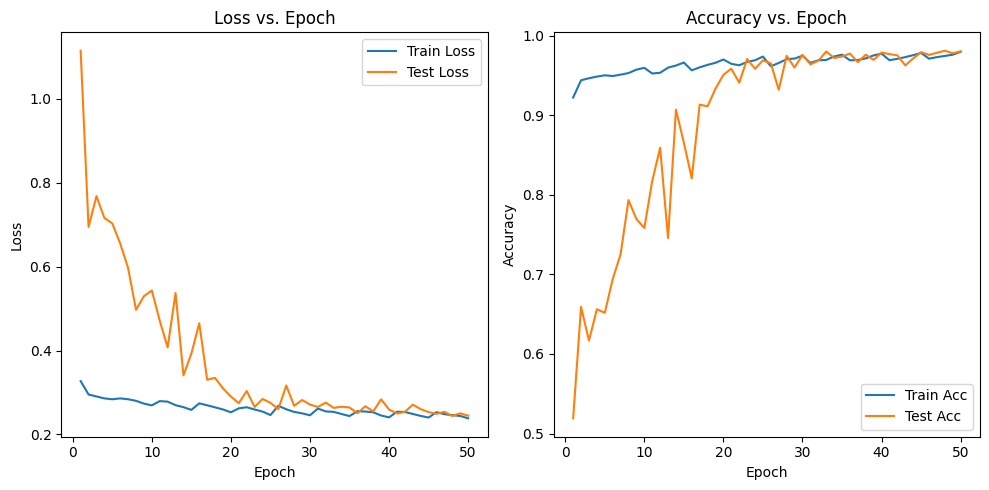

In [ ]:
# Plotting
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accuracies, label="Train Acc")
plt.plot(epochs_range, val_accuracies, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pickle
filename = 'hybrid_cnn_vit.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)